In [3]:
!pip install gensim==3.8.1


In [5]:
## for data
import datasets  #(1.13.3)
import pandas as pd  #(0.25.1)
import numpy  #(1.16.4)
## for plotting
import matplotlib.pyplot as plt  #(3.1.2)
import seaborn as sns  #(0.9.0)
## for preprocessing
import re
import nltk  #(3.4.5)
import contractions  #(0.0.18)
## for textrank
import gensim  #(3.8.1)
## for evaluation
import rouge  #(1.0.0)
import difflib
## for seq2seq
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing #(2.6.0)
## for bart
import transformers

ImportError: cannot import name 'Mapping' from 'collections' (c:\Users\Trijal Srivastava\Downloads\anaconda3new\lib\collections\__init__.py)

In [19]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')
lst_dics = [dic for dic in dataset["train"]]
## keep the first N articles if you want to keep it lite 
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(20000)
dtf.head()

Found cached dataset cnn_dailymail (C:/Users/Trijal Srivastava/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [29]:
i = 0
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

In [27]:
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

In [28]:
from summa.summarizer import summarize as textrank

def apply_text_rank(corpus, ratio):
    if type(corpus) is str:
        corpus = [corpus]
    lst_summaries = [textrank(txt, ratio=ratio) for txt in corpus]
    return lst_summaries

# Apply the function to the corpus
predicted = apply_text_rank(corpus=dtf_test["text"], ratio=0.2)
for summary in predicted:
    print(summary)


LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.
"I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.
"But I try very hard not to go that way because it would be too easy for them." His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films.
An inmate housed on the "forgotten floor," where many mentally ill inmates are ho

In [32]:
import numpy as np
'''
Calculate ROUGE score.
:parameter    
    :param y_test: string or list    
    :param predicted: string or list
'''
def evaluate_summary(y_test, predicted):    
   rouge_score = rouge.Rouge()    
   scores = rouge_score.get_scores(y_test, predicted, avg=True)       
   score_1 = round(scores['rouge-1']['f'], 2)    
   score_2 = round(scores['rouge-2']['f'], 2)    
   score_L = round(scores['rouge-l']['f'], 2)    
   print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:",
         score_2, "--> avg rouge:", round(np.mean(
         [score_1,score_2,score_L]), 2))
## Apply the function to predicted
i = 0
evaluate_summary(dtf_test["y"][i], predicted[i])

rouge1: 0.27 | rouge2: 0.18 | rougeL: 0.18 --> avg rouge: 0.24


In [33]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b


'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [34]:
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])
from IPython.core.display import display, HTML
display(HTML(match))

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\4067428227.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [35]:
match = display_string_matching(dtf_test["text"][i], predicted[i], both=True, sentences=True, titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\2097039434.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Trijal
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...


True

In [39]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Trijal
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...


True

In [40]:
## create stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

## apply function to both text and summaries
dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))


C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\2728377597.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\2728377597.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=

In [53]:
dtf_test["text_clean"] = dtf_test["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_test["y_clean"] = dtf_test["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\3164515875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["text_clean"] = dtf_test["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\3164515875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["y_clean"] = dtf_test["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, 

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\4052643109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train['word_count'] = dtf_train['text_clean'].apply(lambda x: len(nltk.word_tokenize(str(x))) )
C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\4052643109.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dtf_train["word_count"], hist=True, kde=True, kde_kws=

<Axes: xlabel='word_count', ylabel='Density'>

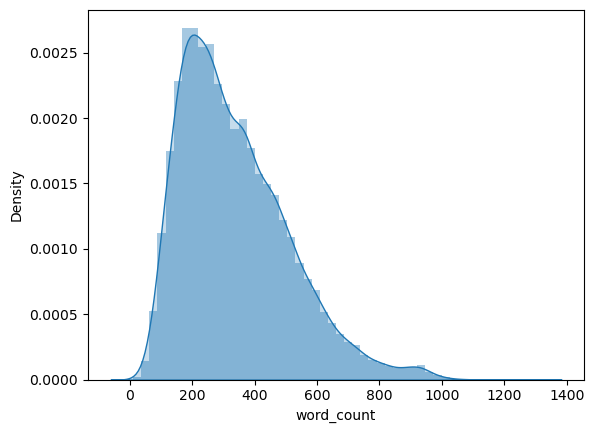

In [43]:
## count
dtf_train['word_count'] = dtf_train['text_clean'].apply(lambda x: len(nltk.word_tokenize(str(x))) )
## plot
sns.distplot(dtf_train["word_count"], hist=True, kde=True, kde_kws={"shade":True})

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\3921872134.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_freq = dtf_freq.append(dtf_n)
C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\3921872134.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))


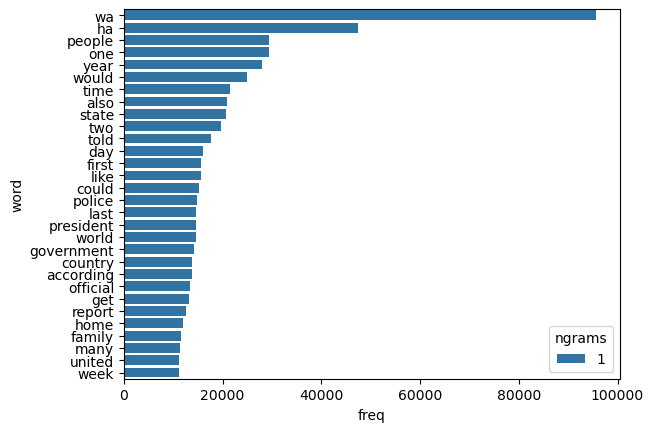

In [45]:
lst_tokens = nltk.tokenize.word_tokenize(dtf_train["text_clean"].str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [49]:
thres = 500 #<-- min frequency
X_top_words = len(dtf_freq_X[dtf_freq_X["freq"]>thres])
print(X_top_words)

2392


In [50]:
lst_corpus = dtf_train["text_clean"]
## tokenize text
tokenizer = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = {"<PAD>":0}
dic_vocabulary.update(tokenizer.word_index)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

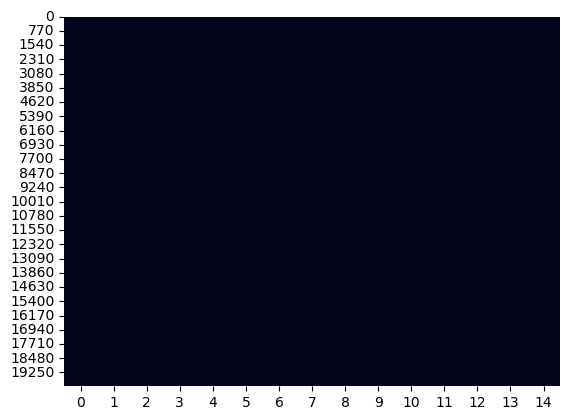

In [51]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()


In [54]:
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(dtf_test["text_clean"])
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [55]:
# Add START and END tokens to the summaries (y)
special_tokens = ("<START>", "<END>")
dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x:special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x:special_tokens[0]+' '+x+' '+special_tokens[1])
# check example
dtf_test["y_clean"][i]

C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\1799244802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x:
C:\Users\Trijal Srivastava\AppData\Local\Temp\ipykernel_10928\1799244802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x:


'<START> harry potter star daniel radcliffe get 20m fortune turn 18 monday young actor ha plan fritter cash away radcliffes earnings first five potter film held trust fund <END>'

In [60]:
import gensim.downloader as api

# Load pre-trained word embeddings
nlp = api.load("glove-wiki-gigaword-300")


[==================================================] 100.0% 376.1/376.1MB downloaded


In [62]:
## start the matrix (length of vocabulary x vector size) with all 0s
X_embeddings = np.zeros((len(X_dic_vocabulary)+1, 300))
for word,idx in X_dic_vocabulary.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

NameError: name 'X_dic_vocabulary' is not defined

In [63]:
lstm_units = 250
embeddings_size = 300
##------------ ENCODER (embedding + lstm) ------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", 
                               input_dim=len(X_dic_vocabulary),
                               output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)
##------------ DECODER (embedding + lstm + dense) ----------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", 
                               input_dim=len(y_dic_vocabulary), 
                               output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense",          layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)
##---------------------------- COMPILE ---------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, 
                     name="Seq2Seq")
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

NameError: name 'X_dic_vocabulary' is not defined